In [133]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error , mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense,Activation,Dropout,Input,LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping


In [134]:
df = pd.read_csv(r"D:\python_jupty\機器學習作業\大里補值完.csv")
df_test = pd.read_csv(r"D:\python_jupty\機器學習作業\大里補值完_2022.csv")

In [135]:
df

,time,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,...,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,aqi,truetime,month,hour
0,44927.00,17.9,2.21,0.45,0.13,0.8,14.0,14.9,13.9,30,...,1.9,2.34,285,260,0.8,0.2,28,2023/1/1 00:00,1,0
1,44927.04,17.7,2.18,0.42,0.12,0.6,15.7,16.4,12.4,27,...,1.2,2.30,319,308,0.9,0.2,31,2023/1/1 00:57,1,1
2,44927.08,17.6,2.22,0.46,0.14,0.4,15.0,15.5,11.3,29,...,1.1,2.36,176,159,0.2,0.1,38,2023/1/1 01:55,1,2
3,44927.13,17.2,2.20,0.50,0.14,1.3,17.9,19.2,4.3,36,...,1.1,2.34,136,135,0.7,0.8,44,2023/1/1 03:07,1,3
4,44927.17,17.0,2.22,0.46,0.13,1.1,15.8,17.0,5.7,32,...,0.9,2.35,256,278,1.5,0.6,54,2023/1/1 04:04,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,45291.79,21.7,2.18,0.57,0.08,0.9,20.3,21.3,37.0,52,...,1.3,2.26,338,332,1.7,1.5,70,2023/12/31 18:57,12,19
8756,45291.83,20.9,2.20,0.58,0.08,0.9,20.2,21.1,38.7,52,...,1.4,2.28,337,313,1.6,1.3,79,2023/12/31 19:55,12,20
8757,45291.88,20.3,2.20,0.56,0.07,0.8,19.3,20.1,41.2,53,...,1.4,2.27,348,339,2.0,1.6,86,2023/12/31 21:07,12,21
8758,45291.92,20.0,2.21,0.55,0.06,0.7,18.2,18.9,40.5,42,...,1.5,2.27,9,351,1.2,1.5,93,2023/12/31 22:04,12,22


In [136]:
df_selected = df.drop(columns=['time','truetime','WD_HR','WIND_DIREC','NO','RAINFALL','hour','month'], inplace=False)#去掉的feature
df_selected_test = df_test.drop(columns=['time','WD_HR','WIND_DIREC','NO','RAINFALL','hour','month'], inplace=False)#去掉的feature
sel_data = 'aqi'  

# Train Test split

In [137]:
import math


time_steps = 4
train = df_selected

test = df_selected_test

In [138]:
train_temp = train.to_numpy()
test_temp = test.to_numpy()

scaler = MinMaxScaler(feature_range=(0, 1))

train_np= scaler.fit_transform(train_temp)
test_np= scaler.fit_transform(test_temp)

In [139]:
print(train_np.shape)

print(test_np.shape)

(8760, 15)
(8760, 15)


# Train

In [140]:

X_train = []
y_train = []

for i in range(0, len(train_np) - time_steps, 24):
    for j in range(i, i+18-time_steps):
        X_train.append(train_np[j:j+time_steps])
        y_train.append(train_np[j+time_steps])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)

(5110, 4, 15)


# Test

In [141]:
x_test = []
y_test = []


for i in range(0, len(train_np) - time_steps, 24):
    for j in range(i, i+18-time_steps):
        x_test.append(test_np[j:j+time_steps])


y_test= test['aqi']

x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_test.shape)
print(y_test.shape)



(5110, 4, 15)
(8760,)


# Model

In [142]:
opt = keras.optimizers.Adam(learning_rate=0.005)


model = Sequential()
model.add(Input(shape=(X_train.shape[1],  X_train.shape[2])))  

model.add(LSTM(32,return_sequences=True,activation='relu') )
model.add(LSTM(16,return_sequences=False,activation='relu') )
 
model.add( Dense(X_train.shape[2],activation='relu') )
model.compile(optimizer=opt, loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)


model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 4, 32)          │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,535 (37.25 KB)

 Trainable params: 9,535 (37.25 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:

tt = 50
history = model.fit(X_train,y_train,batch_size=20,validation_split=0.1,epochs=tt,callbacks=[es],verbose=1,shuffle=False)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0378 - val_loss: 0.0140
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0115
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0108
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - val_loss: 0.0097
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112 - val_loss: 0.0094
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0090
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - val_loss: 0.0042
Epoch 8/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 9/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 10/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 11/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 12/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

# Predict

In [159]:
import random

j = 7
num_steps_to_show = 8
initial_sequence = []
initial_sequence.append(test_np[j:j+time_steps])
initial_sequence = np.array(initial_sequence)


In [160]:
sequence = []
temp = X_train.shape[2]
for i in range(num_steps_to_show):
    new_prediction = model.predict(initial_sequence)

    initial_sequence = initial_sequence[0][1:]
    
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0).reshape(-1,time_steps,X_train.shape[2])
    sequence.append(new_prediction[0][temp-1])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [161]:
sc = MinMaxScaler(feature_range=(0, 1))
y_test= y_test.reshape(-1, 1)
sc.fit(y_test)

sequence = sc.inverse_transform(np.array(sequence).reshape(8,1))

In [162]:
sequence=sequence.astype(int)

In [163]:
mse =mean_squared_error(y_test[j+time_steps:j+time_steps+num_steps_to_show],sequence)
mse
rmse = np.sqrt(mse)
print('rmse:'   ,rmse)
print('mse:',mse)


rmse: 5.326818938165629
mse: 28.375


# 圖

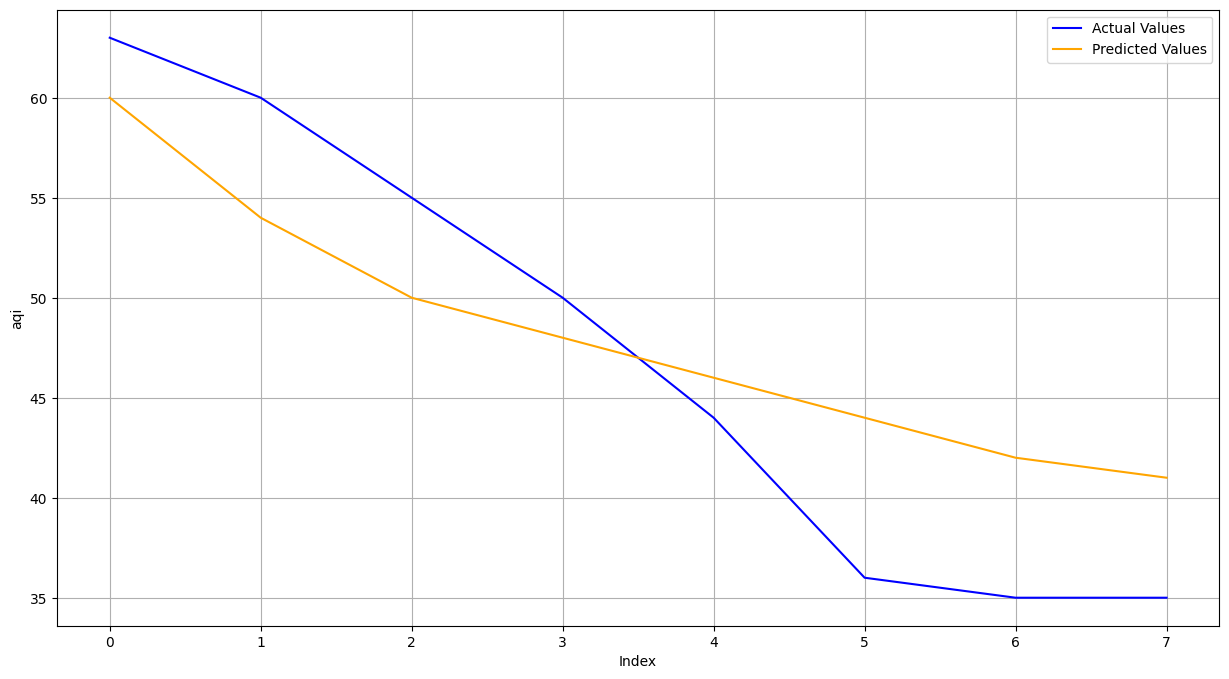

In [164]:

plt.figure(figsize=(15, 8))
plt.plot(y_test[j+time_steps:j+time_steps+num_steps_to_show], label='Actual Values', color='blue', linestyle='-')
plt.plot(sequence[:num_steps_to_show], label='Predicted Values', color='orange', linestyle='-')
plt.xlabel('Index')
plt.ylabel('aqi')
plt.legend()
plt.grid(True)
plt.show()

In [165]:
j=6
k=0
total_rmse=0
while(True):
        initial_sequence = []
        initial_sequence.append(test_np[j-time_steps:j])

        initial_sequence = np.array(initial_sequence)
        sequence = []
        temp = X_train.shape[2]
        for i in range(num_steps_to_show):
            new_prediction = model.predict(initial_sequence,verbose=0)

            initial_sequence = initial_sequence[0][1:]
                   
            initial_sequence = np.append(initial_sequence,new_prediction,axis=0).reshape(-1,time_steps,X_train.shape[2])

            sequence.append(new_prediction[0][temp-1])
            if(new_prediction[0][temp-1]>200):
                print(j+i)
        
        sequence = sc.inverse_transform(np.array(sequence).reshape(num_steps_to_show,1))
        sequence=sequence.astype(int)
        mse =mean_squared_error(y_test[j+time_steps:j+time_steps+num_steps_to_show],sequence)
        rmse = np.sqrt(mse)
        total_rmse+=rmse
        k=k+1
        # print('rmse:',rmse)
        # print('mse:',mse)
        j=j+24
        if(j>8760):
            break
print('rmse:',total_rmse/k)
